# Option 1: Text-to-Image Generation


## Install 


In [24]:
# If you already have torch/torchvision/numpy/matplotlib installed you can skip this cell.
# The `-q` flag keeps output compact.
# !pip install -q torch torchvision torchaudio matplotlib tqdm numpy

## Imports and reproducibility
Set seeds and pick the GPU automatically when available. The same seeds are reused in sampling for repeatability.

In [25]:
import math
import os
import random
from typing import Dict, List, Tuple

import numpy as np
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms.functional as TF
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

torch.manual_seed(42)
np.random.seed(42)
random.seed(42)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


## Data loading and prep
The dataset ships as `data/circle.npy`, `data/triangle.npy`, and `data/square.npy`. Each array contains grayscale drawings. To keep epochs bounded around ~6k samples, the loader optionally caps each class. Light geometric jittering helps the tiny model generalize and prevents collapse.

In [26]:
class ShapeTextDataset(Dataset):
    def __init__(self, data_dir: str = "/kaggle/input/data-circle-square-triangle", img_size: int = 32, max_items_per_class: int = 2000, augment: bool = True):
        self.samples: List[Tuple[np.ndarray, str]] = []
        prompt_map = {
            "circle": "a hand-drawn circle",
            "square": "a hand-drawn square",
            "triangle": "a hand-drawn triangle",
        }
        for name in ["circle", "square", "triangle"]:
            path = os.path.join(data_dir, f"{name}.npy")
            # mmap keeps load time bounded even if the raw files contain far more than the capped subset
            arr = np.load(path, mmap_mode="r")
            arr = arr[:max_items_per_class]
            if arr.ndim == 4:  # (N,H,W,C)
                arr = arr[..., 0]
            self.samples.extend([(img.astype(np.float32), prompt_map[name]) for img in arr])
        self.img_size = img_size
        self.augment = augment

    def __len__(self):
        return len(self.samples)

    def _prepare_tensor(self, img: np.ndarray) -> torch.Tensor:
        tensor = torch.as_tensor(img, dtype=torch.float32)
        if tensor.ndim == 1:
            side = int(math.sqrt(tensor.numel()))
            tensor = tensor.view(side, side)
        if tensor.ndim == 2:
            tensor = tensor.unsqueeze(0)
        if tensor.shape[0] > 1:
            tensor = tensor.mean(dim=0, keepdim=True)
        return tensor

    def __getitem__(self, idx):
        img, prompt = self.samples[idx]
        img = self._prepare_tensor(img)
        img = TF.resize(img, [self.img_size, self.img_size])
        if self.augment:
            angle = random.uniform(-8, 8)
            img = TF.rotate(img, angle, fill=0.0)
            img = TF.affine(img, angle=0.0, translate=(random.uniform(-2, 2), random.uniform(-2, 2)), scale=1.0, shear=0.0, fill=0.0)
        img = (img / 255.0).clamp(0, 1) * 2 - 1
        return img, prompt


def get_dataloader(batch_size=32, img_size=32, max_items_per_class=2000, augment=True, num_workers=None):
    dataset = ShapeTextDataset(img_size=img_size, max_items_per_class=max_items_per_class, augment=augment)
    if num_workers is None:
        if os.name == "nt":
            # Windows prefers the main process; worker spawn can otherwise stall the first batch
            num_workers = 0
        else:
            cpu_budget = max(1, (os.cpu_count() or 2) - 1)
            num_workers = min(2, cpu_budget)
    persistent = num_workers > 0 and os.name != "nt"
    print(f"Loaded {len(dataset)} total sketches (cap {max_items_per_class} per class) using {num_workers} worker(s)")
    return DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        persistent_workers=persistent,
        pin_memory=torch.cuda.is_available(),
    )


# Default training loader now automatically disables extra workers on Windows to keep progress bars responsive
dataloader = get_dataloader(batch_size=16, img_size=32)


Loaded 6000 total sketches (cap 2000 per class) using 2 worker(s)


### Quick look at data
Confirm that the images align with the prompts after preprocessing.

### Quick sanity-check batch
If the preview below ever hangs for more than a minute, drop `num_workers` to 0. 
The cap of 64 sketches per class and `mmap` loading keeps the first batch fast (a few seconds).


Loaded 192 total sketches (cap 64 per class) using 0 worker(s)


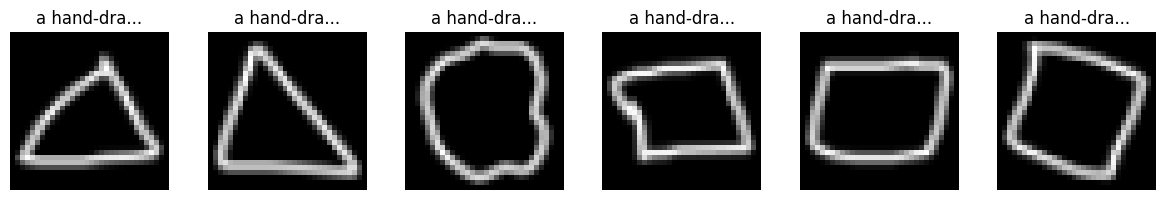

In [27]:
preview_loader = get_dataloader(batch_size=6, img_size=32, max_items_per_class=64, augment=False, num_workers=0)
imgs, prompts = next(iter(preview_loader))
fig, axes = plt.subplots(1, 6, figsize=(12, 2))
for i in range(6):
    ax = axes[i]
    ax.imshow(((imgs[i].squeeze() + 1) / 2).clamp(0, 1), cmap="gray")
    ax.set_title(prompts[i][:10] + "...")
    ax.axis("off")
plt.tight_layout()
plt.show()


## Diffusion helpers
Cosine noise schedule with sinusoidal time embeddings. The helper functions implement the forward process and sampling utilities.

In [28]:
def cosine_beta_schedule(timesteps, s=0.008):
    steps = timesteps + 1
    x = torch.linspace(0, timesteps, steps)
    alphas_cumprod = torch.cos(((x / timesteps) + s) / (1 + s) * math.pi * 0.5) ** 2
    alphas_cumprod = alphas_cumprod / alphas_cumprod[0]
    betas = 1 - (alphas_cumprod[1:] / alphas_cumprod[:-1])
    return torch.clip(betas, 0.0001, 0.9999)

T = 300
betas = cosine_beta_schedule(T)
alphas = 1.0 - betas
alpha_cum = torch.cumprod(alphas, dim=0)
alpha_cum_prev = torch.cat([torch.ones(1), alpha_cum[:-1]])

def extract(a, t, x_shape):
    b, *_ = t.shape
    out = a.gather(-1, t.cpu()).float().to(t.device)
    return out.reshape(b, *((1,) * (len(x_shape) - 1)))

def q_sample(x_start, t, noise=None):
    if noise is None:
        noise = torch.randn_like(x_start)
    return extract(alpha_cum.sqrt(), t, x_start.shape) * x_start + extract((1 - alpha_cum).sqrt(), t, x_start.shape) * noise

def p_mean_variance(model, x, t, t_emb, text_emb):
    pred_noise = model(x, t_emb, text_emb)
    beta_t = extract(betas, t, x.shape)
    alpha_t = extract(alphas, t, x.shape)
    alpha_cum_t = extract(alpha_cum, t, x.shape)
    coef1 = 1 / torch.sqrt(alpha_t)
    coef2 = beta_t / torch.sqrt(1 - alpha_cum_t)
    mean = coef1 * (x - coef2 * pred_noise)
    var = beta_t
    return mean, var, pred_noise

@torch.no_grad()
def p_sample(model, x, t, t_emb, text_emb):
    mean, var, pred_noise = p_mean_variance(model, x, t, t_emb, text_emb)
    if (t == 0).all():
        return mean, pred_noise
    noise = torch.randn_like(x)
    return mean + torch.sqrt(var) * noise, pred_noise


## Text encoder and tiny U-Net
GRU-based text encoder feeds a light U-Net. Time and text embeddings are injected into each block to keep conditioning stable. An EMA copy of the network is maintained for sharper sampling.

In [29]:
class TextEncoder(nn.Module):
    def __init__(self, embed_dim=128, hidden_dim=192):
        super().__init__()
        self.embedding = nn.Embedding(1024, embed_dim)
        self.rnn = nn.GRU(embed_dim, hidden_dim, batch_first=True)
        self.proj = nn.Linear(hidden_dim, hidden_dim)

    def forward(self, tokens):
        emb = self.embedding(tokens)
        _, h = self.rnn(emb)
        return self.proj(h.squeeze(0))

def tokenize(prompts: List[str], vocab=None, max_len=16):
    if vocab is None:
        vocab = {}
    token_lists = []
    for text in prompts:
        tokens = []
        for word in text.lower().split():
            if word not in vocab:
                vocab[word] = len(vocab) + 1
            tokens.append(vocab[word])
        token_lists.append(tokens[:max_len])
    max_len = max(len(t) for t in token_lists)
    padded = []
    for t in token_lists:
        padded.append(t + [0] * (max_len - len(t)))
    return torch.tensor(padded, dtype=torch.long), vocab

def sinusoidal_embedding(n, d):
    pos = torch.arange(n)[:, None]
    dim = torch.arange(d)[None, :]
    angle = pos / (10000 ** (2 * (dim // 2) / d))
    emb = torch.zeros((n, d))
    emb[:, 0::2] = torch.sin(angle[:, 0::2])
    emb[:, 1::2] = torch.cos(angle[:, 1::2])
    return emb

class ConvBlock(nn.Module):
    def __init__(self, in_ch, out_ch):
        super().__init__()
        self.block = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.GroupNorm(1, out_ch),
            nn.SiLU(),
        )

    def forward(self, x):
        return self.block(x)

class TinyUNet(nn.Module):
    def __init__(self, base=32, time_dim=128, text_dim=192):
        super().__init__()
        self.time_mlp = nn.Sequential(nn.Linear(time_dim, time_dim), nn.SiLU())
        self.text_mlp = nn.Sequential(nn.Linear(text_dim, text_dim), nn.SiLU())
        cond_channels = {"d1": base, "d2": base * 2, "mid": base * 4, "u1": base * 2, "u2": base}
        self.time_proj = nn.ModuleDict({k: nn.Linear(time_dim, v) for k, v in cond_channels.items()})
        self.text_proj = nn.ModuleDict({k: nn.Linear(text_dim, v) for k, v in cond_channels.items()})

        self.down1 = ConvBlock(1, base)
        self.down2 = ConvBlock(base, base * 2)
        self.to_vec = ConvBlock(base * 2, base * 4)
        self.up1 = ConvBlock(base * 4, base * 2)
        self.up2 = ConvBlock(base * 2, base)
        self.skip_proj = nn.Conv2d(base, base * 2, 1)
        self.out = nn.Conv2d(base, 1, 1)

    def _inject(self, feat, name, t_feat, txt_feat):
        t = self.time_proj[name](t_feat)[:, :, None, None]
        txt = self.text_proj[name](txt_feat)[:, :, None, None]
        return feat + t + txt

    def forward(self, x, t_embed, text_embed):
        t_feat = self.time_mlp(t_embed)
        txt_feat = self.text_mlp(text_embed)

        d1 = self.down1(x)
        d1 = self._inject(d1, "d1", t_feat, txt_feat)
        d2 = self.down2(nn.functional.avg_pool2d(d1, 2))
        d2 = self._inject(d2, "d2", t_feat, txt_feat)
        mid = self.to_vec(d2)
        mid = self._inject(mid, "mid", t_feat, txt_feat)
        u1 = nn.functional.interpolate(self.up1(mid), scale_factor=2, mode="nearest")
        skip = self.skip_proj(d1)
        u1 = self._inject(u1 + skip, "u1", t_feat, txt_feat)
        u2 = self.up2(u1)
        u2 = self._inject(u2, "u2", t_feat, txt_feat)
        return self.out(u2)

## Training loop
The model predicts the noise added at timestep *t*. EMA smoothing, gradient clipping, and a cosine learning rate schedule stabilize training. Default settings keep each epoch to the ~6k sketches cap; increase `max_items_per_class` to use the full dataset.

In [ ]:
text_encoder = TextEncoder().to(device)
model = TinyUNet().to(device)
ema_model = TinyUNet().to(device)
ema_model.load_state_dict(model.state_dict())
ema_decay = 0.995

optimizer = torch.optim.Adam(list(model.parameters()) + list(text_encoder.parameters()), lr=2e-4)
vocab: Dict[str, int] = {}

def get_time_embedding(timesteps, dim=128):
    emb = sinusoidal_embedding(max(T, timesteps.max().item() + 1), dim).to(device)
    return emb[timesteps]

def update_ema(model_src, model_tgt, decay):
    with torch.no_grad():
        for p_src, p_tgt in zip(model_src.parameters(), model_tgt.parameters()):
            p_tgt.mul_(decay).add_(p_src, alpha=1 - decay)

def p_losses(x0, prompts):
    b = x0.shape[0]
    t = torch.randint(0, T, (b,), device=device).long()
    noise = torch.randn_like(x0)
    x_noisy = q_sample(x0, t, noise)
    global vocab
    token_batch, vocab = tokenize(list(prompts), vocab)
    token_batch = token_batch.to(device)
    text_emb = text_encoder(token_batch)
    t_emb = get_time_embedding(t)
    pred = model(x_noisy, t_emb, text_emb)
    return nn.functional.mse_loss(pred, noise)

def train(epochs=5, grad_clip=1.0, checkpoint_dir="/kaggle/working/"):
    global ema_model
    os.makedirs(checkpoint_dir, exist_ok=True)
    lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs * len(dataloader), eta_min=5e-5)
    total_steps = epochs * len(dataloader)
    progress = tqdm(total=total_steps, desc="training")
    for epoch in range(epochs):
        loop = tqdm(dataloader, desc=f"epoch {epoch+1}/{epochs}", leave=False)
        for imgs, prompts in loop:
            imgs = imgs.to(device)
            loss = p_losses(imgs, prompts)
            optimizer.zero_grad()
            loss.backward()
            nn.utils.clip_grad_norm_(list(model.parameters()) + list(text_encoder.parameters()), grad_clip)
            optimizer.step()
            update_ema(model, ema_model, ema_decay)
            lr_scheduler.step()
            loop.set_postfix(loss=loss.item())
            progress.update(1)
            progress.set_postfix(loss=loss.item(), complete=f"{progress.n / total_steps:.0%}")
        checkpoint = {"model": model.state_dict(), "ema": ema_model.state_dict(), "text": text_encoder.state_dict(), "vocab": vocab}
        epoch_path = os.path.join(checkpoint_dir, f"shape_diffusion_epoch_{epoch+1}.pt")
        torch.save(checkpoint, epoch_path)
        torch.save(checkpoint, os.path.join(checkpoint_dir, "shape_diffusion_latest.pt"))
        print(f"Epoch {epoch+1} checkpoint saved to {epoch_path}")
    progress.close()

# Kick off training (adjust epochs upward for higher fidelity once you are satisfied with runtime)
train(epochs=15)


training:   0%|          | 0/5625 [00:00<?, ?it/s]

epoch 1/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 1 checkpoint saved to /kaggle/working/shape_diffusion_epoch_1.pt


epoch 2/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 2 checkpoint saved to /kaggle/working/shape_diffusion_epoch_2.pt


epoch 3/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 3 checkpoint saved to /kaggle/working/shape_diffusion_epoch_3.pt


epoch 4/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 4 checkpoint saved to /kaggle/working/shape_diffusion_epoch_4.pt


epoch 5/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 5 checkpoint saved to /kaggle/working/shape_diffusion_epoch_5.pt


epoch 6/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 6 checkpoint saved to /kaggle/working/shape_diffusion_epoch_6.pt


epoch 7/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 7 checkpoint saved to /kaggle/working/shape_diffusion_epoch_7.pt


epoch 8/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 8 checkpoint saved to /kaggle/working/shape_diffusion_epoch_8.pt


epoch 9/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 9 checkpoint saved to /kaggle/working/shape_diffusion_epoch_9.pt


epoch 10/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 10 checkpoint saved to /kaggle/working/shape_diffusion_epoch_10.pt


epoch 11/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 11 checkpoint saved to /kaggle/working/shape_diffusion_epoch_11.pt


epoch 12/15:   0%|          | 0/375 [00:00<?, ?it/s]

Epoch 12 checkpoint saved to /kaggle/working/shape_diffusion_epoch_12.pt


epoch 13/15:   0%|          | 0/375 [00:00<?, ?it/s]

## Sampling from the model
Start from random noise and apply the reverse diffusion steps conditioned on a prompt. EMA weights are preferred; if training is skipped, fall back to the current model parameters.

sampling: 0it [00:00, ?it/s]

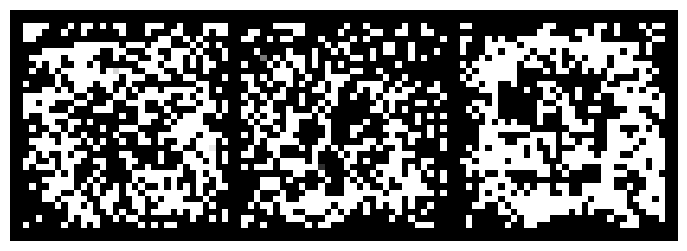

In [31]:
@torch.no_grad()
def sample(prompts: List[str], use_ema: bool = True):
    model_to_use = ema_model if use_ema else model
    model_to_use.eval()
    global vocab
    token_batch, vocab = tokenize(prompts, vocab)
    token_batch = token_batch.to(device)
    text_emb = text_encoder(token_batch)
    b = len(prompts)
    img = torch.randn(b, 1, 32, 32, device=device)
    for i in tqdm(reversed(range(T)), desc="sampling"):
        t = torch.full((b,), i, device=device, dtype=torch.long)
        t_emb = get_time_embedding(t)
        img, _ = p_sample(model_to_use, img, t, t_emb, text_emb)
    img = img.clamp(-1, 1)
    return img

example_prompts = [
    "a hand-drawn circle",
    "a hand-drawn triangle",
    "a hand-drawn square",
]

samples = sample(example_prompts)
grid = make_grid(samples, nrow=3, normalize=True, value_range=(-1, 1))
plt.figure(figsize=(9, 3))
plt.imshow(grid.permute(1, 2, 0).cpu().numpy(), cmap="gray")
plt.axis("off")
plt.show()